dataset : https://www.kaggle.com/c/street-view-getting-started-with-julia

In [1]:
import os
import csv
import random
import math
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn import ensemble
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics

from skimage import io
from skimage import color
from skimage import feature
from skimage import transform

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

%matplotlib inline

Using TensorFlow backend.


In [2]:
#labels csv
labels_ = [] # first line is dirty
with open('./trainLabels.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        labels_.append(row[1])


In [3]:
#loading the dataset
images = []
labels = []
SAMPLE_DIR = './trainResized'
for i, label in enumerate(labels_):
    if i == 0 : continue
    labels.append(label)
    im = io.imread('{}/{}.Bmp'.format(SAMPLE_DIR, i))
    gray = color.rgb2gray(im)
    ############edges = feature.canny(gray)
    images.append(gray)

images = np.array(images)
labels = np.array(labels)

print (images.shape, labels.shape)

(6283, 20, 20) (6283,)


# This is the original after loading initial transforms

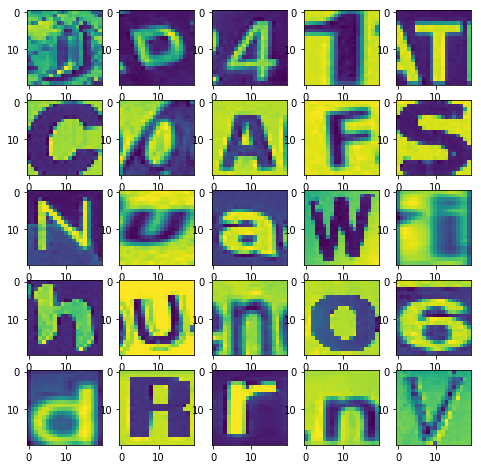

In [4]:
plt.figure(figsize=(8,8))
N = 5
for i in range(N * N):
    plt.subplot(N, N, i+1)
    plt.imshow(images[random.randint(0, len(images)-1)])

In [5]:
# filtering the set
# this is optional!

letters = ['A', 'B', 'C', 'D', 'E','F', 'G', 'H', 'X', 'Y', 
           '1', '2','3', '4', '5', '6', '7', '8', '9', '0',
          'a', 'b', 'c', 'd', 'e', 'f']
          


#letters = ['A', 'B', 'C', 'D', 'E','F', 'G', 'H', 'X', 'Y']
#letters = list(set(labels))

mask = (labels == letters[0])
for i in range(len(letters)-1):
    mask = mask | (labels == letters[i+1])

images = images[mask]
labels = labels[mask]
print (images.shape, labels.shape)



(2627, 20, 20) (2627,)


In [6]:
# splitting for training ant testing
images_train, images_test, labels_train, labels_test = model_selection.train_test_split(images, labels, test_size=0.33, random_state=45)
print (images_train.shape, images_test.shape, labels_train.shape, labels_test.shape)



(1760, 20, 20) (867, 20, 20) (1760,) (867,)


# In these 2 steps we are normalizing the set to have equal number of samples for all cathegory -- also generating new smaples

In [7]:
#label stats
def label_stats(labels, letters):
    stats = {}
    for letter in letters:
        stats[letter] = len(labels[labels == letter])
    return stats

print (label_stats(labels, letters))
print (label_stats(labels_train, letters))
print (images_train.shape, labels_train.shape)

{'B': 90, 'Y': 54, 'E': 357, 'd': 54, 'G': 111, 'b': 25, 'f': 28, '1': 65, 'D': 165, '9': 36, '5': 41, '6': 42, 'H': 152, 'A': 459, '7': 31, 'e': 196, '4': 37, 'C': 170, 'F': 69, '3': 36, 'c': 52, '8': 21, 'a': 156, '2': 59, 'X': 43, '0': 78}
{'B': 58, 'Y': 43, 'E': 234, 'd': 33, 'G': 66, 'b': 16, 'f': 17, '1': 37, 'D': 121, '9': 27, '5': 30, '6': 27, 'H': 106, 'A': 320, '7': 18, 'e': 134, '4': 23, 'C': 116, 'F': 44, '3': 25, 'c': 28, '8': 17, 'a': 103, '2': 36, 'X': 24, '0': 57}
(1760, 20, 20) (1760,)


In [8]:
# generates more images the way that every sample has equal number
def generate_and_eq_more_images(images, labels, letters):
    
    im_list = images.tolist()
    labels_list = labels.tolist()
    
    stats = label_stats(labels, letters)
    max_sample_size = max(stats.values()) # the maximus sample size
    print ("Max: ", max_sample_size )
    for letter in letters:
        samples_to_gen = max_sample_size - stats[letter] # number of new samples to be generated
        sample_images = images[labels == letter] # original image sample, this is the source for the generated images
        print("label ", letter, samples_to_gen)
        for i in range(samples_to_gen): #adding generated images N times
            random_im = sample_images[random.randint(0,len(sample_images)-1)]
            im_list.append(gen_transform(random_im))
            labels_list.append(letter)
            
    return np.array(im_list), np.array(labels_list)
    
def gen_transform(im):
    new_im = transform.rotate(im, random.randint(-20, 20))
    return new_im
    
    
    
images_train, labels_train = generate_and_eq_more_images(images_train, labels_train, letters)

print (images_train.shape, labels_train.shape)
print (label_stats(labels_train, letters))

Max:  320
label  A 0
label  B 262
label  C 204
label  D 199
label  E 86
label  F 276
label  G 254
label  H 214
label  X 296
label  Y 277
label  1 283
label  2 284
label  3 295
label  4 297
label  5 290
label  6 293
label  7 302
label  8 303
label  9 293
label  0 263
label  a 217
label  b 304
label  c 292
label  d 287
label  e 186
label  f 303
(8320, 20, 20) (8320,)
{'B': 320, 'Y': 320, 'E': 320, 'd': 320, 'G': 320, 'b': 320, 'f': 320, '1': 320, 'D': 320, '9': 320, '5': 320, '6': 320, 'H': 320, 'A': 320, '7': 320, 'e': 320, '4': 320, 'C': 320, 'F': 320, '3': 320, 'c': 320, '8': 320, 'a': 320, '2': 320, 'X': 320, '0': 320}


In [9]:
## the canny transform
# the preprocess function
def preprocess_images(img_list):
    im_list = []
    for i in range(len(img_list)):
        aaa = feature.canny(img_list[i], sigma = 0.1)
        aa = feature.canny(img_list[i], sigma = 0.2)
        a = feature.canny(img_list[i], sigma = 0.5)

        b = feature.canny(img_list[i], sigma = 1)
        c = feature.canny(img_list[i], sigma = 2)
        d = feature.canny(img_list[i], sigma = 3)
        
        upper = np.concatenate((aaa, b, d), axis = 1)
        im_list.append(upper)
        #bottom = np.concatenate((b, c, d), axis = 1)
        #im_list.append(np.concatenate((upper, bottom)))

    return np.array(im_list)

images_train = preprocess_images(images_train)

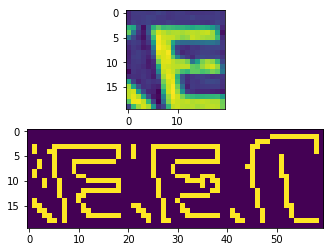

In [10]:
N = 500
im = images[N]

plt.subplot(2,1,1)
plt.imshow(im)
plt.subplot(2,1,2)
plt.imshow(preprocess_images([im])[0])


# This is what the machine sees -- after canny transform

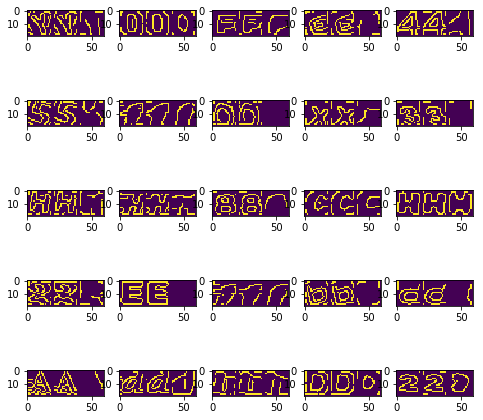

In [11]:
plt.figure(figsize=(8,8))
N = 5
for i in range(N * N):
    plt.subplot(N, N, i+1)
    plt.imshow(images_train[random.randint(0, len(images_train)-1)])

# The Random forest way

In [165]:
x_train = images_train.reshape(images_train.shape[0], -1)
x_test = preprocess_images(images_test)
x_test = x_test.reshape(x_test.shape[0], -1)

y_train = labels_train
y_test = labels_test

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)


(8320, 2400) (867, 2400) (8320,) (867,)


In [166]:
#clf = svm.SVC()
clf = ensemble.RandomForestClassifier()

clf.fit(x_train, y_train)
clf.score(x_train, y_train)

0.9992788461538461

In [167]:
pred = clf.predict(x_test)
score = metrics.accuracy_score(y_test, pred)
print (score)

0.235294117647


[[62  3  7  1  3  0  3  7  4  2  4  6  2 10  3  2  1  3  3  7  2  0  0  2
   2  0]
 [ 4  1  0  2  6  1  1  2  0  0  1  0  0  0  2  3  0  2  2  0  2  0  0  1
   2  0]
 [ 2  3 20  6  2  0  0  1  0  0  4  0  0  1  1  0  0  1  0  5  1  1  4  0
   0  2]
 [ 4  2  7 14  0  0  1  0  0  1  1  1  1  0  1  0  1  0  0  7  0  1  1  1
   0  0]
 [ 3  9  4  3 23 12  4  4  0  0  5  6  5  5  8  7  2  2  1  3  7  2  0  1
   6  1]
 [ 0  1  1  1  5  8  0  3  0  0  1  0  1  0  0  0  1  0  0  1  1  0  0  0
   0  1]
 [ 7  0  3  4  2  0  1  1  3  1  2  0  3  1  0  2  0  0  2  8  2  1  1  0
   1  0]
 [ 3  3  1  0  4  5  3 12  0  0  2  2  2  0  0  1  0  2  0  1  2  0  2  0
   1  0]
 [ 0  0  0  0  0  0  1  1  4  3  5  1  0  0  0  0  0  1  1  0  1  0  0  0
   0  1]
 [ 1  1  0  0  1  0  1  0  0  4  1  0  1  0  0  0  0  0  1  0  0  0  0  0
   0  0]
 [ 2  0  4  1  0  0  0  1  1  1 10  1  1  0  0  0  0  0  0  3  1  0  1  0
   0  1]
 [ 3  1  0  0  1  0  0  2  0  1  1  4  2  1  0  1  3  1  1  0  0  0  0  1
   0  0]
 [ 0

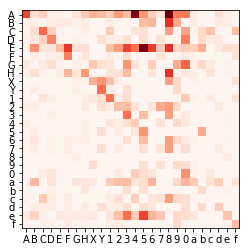

In [168]:
cm = metrics.confusion_matrix(y_test, pred, labels=letters)
print(cm)
cm = cm / cm.sum(axis=1)
plt.xticks(np.arange(len(letters)), letters)
plt.yticks(np.arange(len(letters)), letters)
plt.imshow(cm, cmap = plt.cm.Reds)

# The neural network way


In [12]:
# binarizing the labels
lb = preprocessing.LabelBinarizer()
lb.fit(labels)
yy_train = lb.transform(labels_train)
yy_test = lb.transform(labels_test)

xx_train = images_train.reshape(images_train.shape[0], images_train.shape[1], images_train.shape[2], -1)
xx_test = preprocess_images(images_test)
xx_test = xx_test.reshape(xx_test.shape[0], xx_test.shape[1], xx_test.shape[2], -1)
print (xx_train.shape, xx_test.shape, yy_train.shape, yy_test.shape)



(8320, 20, 60, 1) (867, 20, 60, 1) (8320, 26) (867, 26)


In [43]:
model = Sequential()
B = 2

model.add(Convolution2D(16, B, B, input_shape = (xx_train.shape[1], xx_train.shape[2], 1)))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.1))
model.add(Activation('relu'))
print (model.output)

model.add(Convolution2D(32, B, B))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.1))
model.add(Activation('relu'))
print (model.output)

model.add(Flatten())
print (model.output)

model.add(Dense(4 * 14 * 32))
print (model.output)

model.add(Dense(4 * 14 * 32))
print (model.output)

#model.add(Dense(512))
#print (model.output)

model.add(Dense(512))
print (model.output)




model.add(Dense(yy_train.shape[1]))
print (model.output)


Tensor("Relu_24:0", shape=(?, 9, 29, 16), dtype=float32)
Tensor("Relu_25:0", shape=(?, 4, 14, 32), dtype=float32)
Tensor("Reshape_38:0", shape=(?, ?), dtype=float32)
Tensor("add_211:0", shape=(?, 1792), dtype=float32)
Tensor("add_212:0", shape=(?, 1792), dtype=float32)
Tensor("add_213:0", shape=(?, 512), dtype=float32)
Tensor("add_214:0", shape=(?, 26), dtype=float32)


In [44]:
model.compile(optimizer="adam", loss="mse", metrics=['accuracy'])

In [48]:
E = 20
history = model.fit(xx_train, yy_train, nb_epoch=E, batch_size=500
                   , validation_data = (xx_test, yy_test))

Train on 8320 samples, validate on 867 samples
Epoch 1/20
8320/8320 [==============================] - 9s - loss: 0.0274 - acc: 0.7099 - val_loss: 0.0279 - val_acc: 0.6701
Epoch 2/20
8320/8320 [==============================] - 8s - loss: 0.0269 - acc: 0.7268 - val_loss: 0.0276 - val_acc: 0.6609
Epoch 3/20
8320/8320 [==============================] - 8s - loss: 0.0267 - acc: 0.7345 - val_loss: 0.0280 - val_acc: 0.6494
Epoch 4/20
8320/8320 [==============================] - 8s - loss: 0.0265 - acc: 0.7385 - val_loss: 0.0275 - val_acc: 0.6840
Epoch 5/20
8320/8320 [==============================] - 9s - loss: 0.0267 - acc: 0.7346 - val_loss: 0.0286 - val_acc: 0.6448
Epoch 6/20
8320/8320 [==============================] - 8s - loss: 0.0274 - acc: 0.7177 - val_loss: 0.0275 - val_acc: 0.6655
Epoch 7/20
8320/8320 [==============================] - 8s - loss: 0.0268 - acc: 0.7364 - val_loss: 0.0282 - val_acc: 0.6586
Epoch 8/20
8320/8320 [==============================] - 8s - loss: 0.0262 - ac

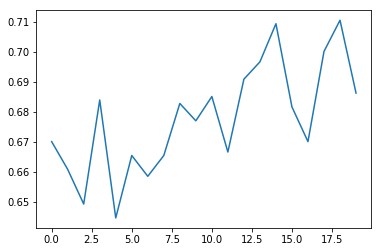

In [49]:
plt.plot(history.history['val_acc'])

0.686274509804


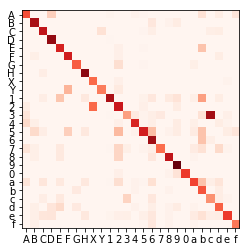

In [50]:
pred = np.argmax(model.predict(xx_test), axis=1)
truth = np.argmax(yy_test, axis=1)

print(metrics.accuracy_score(truth, pred))

cm = metrics.confusion_matrix(truth, pred)
#print(cm)
cm = cm / cm.sum(axis=1)
plt.xticks(np.arange(len(letters)), letters)
plt.yticks(np.arange(len(letters)), letters)
plt.imshow(cm, cmap = plt.cm.Reds)


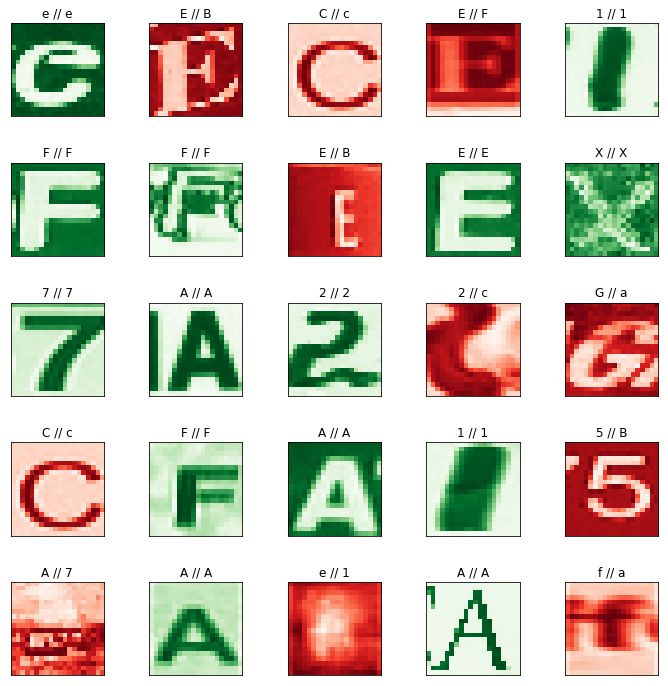

In [55]:
plt.figure(figsize=(12,12))
plt.subplots_adjust(hspace = 0.5)

N = 5
for i in range(N * N):
    plt.subplot(N,N, i+1)
    R = random.randint(0, images_test.shape[0]-1)
    img = images_test[R]
    label = labels_test[R]
    
    pred = model.predict(preprocess_images([img]).reshape(1, 20, 60, -1))
    label_pred = lb.inverse_transform(pred)[0]
    cmap = 'Greens'
    if label != label_pred : cmap = 'Reds'
    plt.imshow(img, cmap = cmap)
    plt.xticks([])
    plt.yticks([])    
    plt.title(label + ' // ' + label_pred )

In [97]:
model.save('my_model1.h5')